In [18]:
# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
import os
import torch
import torchvision
import torch.utils.data
from PIL import Image

In [20]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder


transform = transforms.Compose([transforms.ToTensor()])

# path = r"/content/drive/MyDrive/Datasets for glycoma/MyOrigaFolder" #for colab
path = r"D:\Datasets\MyOrigaFolder"  # for windows
my_ds1 = ImageFolder(path, transform=transform)

In [21]:
img, label = my_ds1[0]
print(img)
print(label)

tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
0


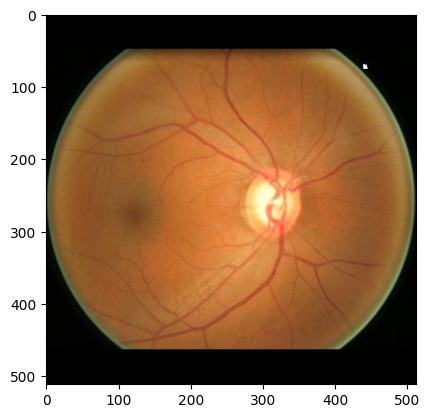

In [22]:
import matplotlib.pyplot as plt

plt.imshow(my_ds1[0][0].permute(1, 2, 0))

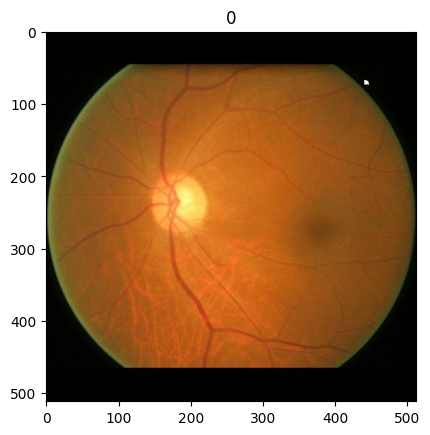

In [23]:
from torch.utils.data import Dataset
import torchvision.transforms as tt
# see youtube vid about how to create custom datasets
# https://www.analyticsvidhya.com/blog/2021/09/torch-dataset-and-dataloader-early-loading-of-data/
# https://youtu.be/NVxCKdp0NhQ


class CustomDS(Dataset):
    def __init__(self, dataAndLables):
        self.dataAndLabels = dataAndLables

    def __len__(self):
        return len(self.dataAndLabels)

    def __getitem__(self, index):
        img = self.dataAndLabels[index][0]
        label = self.dataAndLabels[index][1]
        return img, torch.Tensor([label])

# Since I split the dataset into 2 folders with class 0 and 1 there is no need for custom DS
# ds = CustomDS(dataAndLables)


dataloader = torch.utils.data.DataLoader(my_ds1, batch_size=36, shuffle=False)

toPil = tt.ToPILImage()

for img, label in dataloader:
    plt.title(label=label[35].item())
    plt.imshow(toPil(img[35]))
    break


# checked the customDS and dataloader, and they were tested/crosschecked to be found ok, img 36 in OG dataset is with glycoma and the label we got from dataloader is 1

In [24]:


train_ds, test_ds = torch.utils.data.random_split(
    dataset=my_ds1, lengths=[0.7, 0.3])
print(len(train_ds))
print(len(test_ds))
print(len(train_ds) + len(test_ds))

455
195
650


In [25]:
import torchvision.transforms as tt
train_transforms = tt.Compose([
    tt.RandomHorizontalFlip(),
    tt.RandomVerticalFlip(),
    tt.ToTensor()
])

toPIL = tt.ToPILImage()

my_ds1 = None  # this souldnt be used now so mark it as None

my_ds = ImageFolder(path, transform=train_transforms)
train_ds, test_ds = torch.utils.data.random_split(
    dataset=my_ds, lengths=[0.7, 0.3])
print(len(train_ds))
print(len(test_ds))
print(len(train_ds) + len(test_ds))

455
195
650


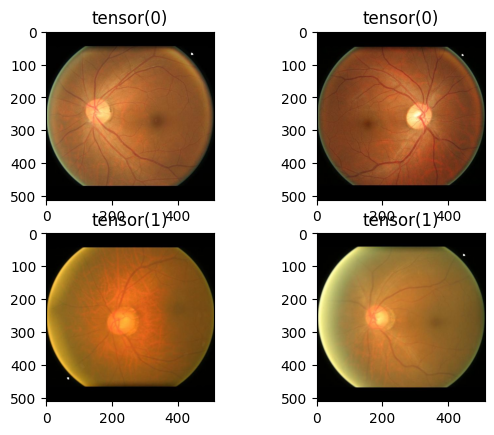

In [26]:
trainLoader = torch.utils.data.DataLoader(train_ds, 4, shuffle=True,)
testLoader = torch.utils.data.DataLoader(test_ds, 4, shuffle=False,)

# lets see if we can apply our transforms
for img, label in testLoader:

    # transformed_imgs_batch = [train_transforms(one_img) for one_img in img] #train_transforms can only take one img at a time

    plt.subplot(2, 2, 1)
    plt.title(label=label[0])
    plt.imshow(img[0].permute(1, 2, 0))

    plt.subplot(2, 2, 2)
    plt.title(label[0])
    # applying/testing our trnsform func, FIRST APPLY the transforms func then apply the .premute()
    plt.imshow(img[1].permute(1, 2, 0))

    plt.subplot(2, 2, 3)
    plt.title(label[2])
    plt.imshow(img[2].permute(1, 2, 0))

    plt.subplot(2, 2, 4)
    plt.title(label[3])
    plt.imshow(img[3].permute(1, 2, 0))

    break

In [27]:
import torch.nn as nn
import torch.functional as F

In [35]:
# IMPORANT!!!!!!!!!!!!!!!! These functions return data and do not do it inplace, make sure to assign the return values to a variable


def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda:0')
    else:
        return torch.device('cpu')


def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)


class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [40]:
import torch.nn.functional as F


def train_step(model, input_batch, actual_outputs, loss_func):
        pred = model(input_batch)
        loss = loss_func(pred, actual_outputs)
        return loss

def accuracy(outputs, labels):
        preds = torch.Tensor([[round(x.item())]  for x in outputs]) #the preds should be of shape [4,1]
        preds = to_device(preds, get_default_device()) # IMPORANT!!!!!!!!!!!!!!!! These functions return data and do not do it inplace, make sure to assign the return values to a variable
        acc = torch.sum(preds == labels).item() / len(preds)
        return acc

def validation(model, trainLoader, loss_func):
        with torch.no_grad(): # IMPORTANT!!!!!! Remeber to put with torch.no_grad() when testing the model or the gradients will keep accumulating and the memory will run out
            losses_sum = 0
            accuracies_sum = 0
            counter = 0
            model.eval()
            for imgs, labels in trainLoader:
                predictions = model(imgs)
                labels = torch.unsqueeze(labels, 1) # get the labels to shape [4,1]
                # also change dtype of labels frm int64 to float32
                labels = labels.type(torch.float32)

                loss  = loss_func(predictions, labels)
                losses_sum += loss

                acc = accuracy(predictions, labels)
                accuracies_sum += acc

                counter += 1

                avg_acc = accuracies_sum/counter
                avg_loss = losses_sum/counter

                # print(f" avg_acc = {avg_acc}")

        return avg_acc,avg_loss




def fit_model(model, lr, trainLoader, epochs, opt=torch.optim.Adam, train_transforms=train_transforms, loss_func = F.binary_cross_entropy,):

    optimizer = opt(model.parameters(), lr,)

    for epoch in range(epochs):
        model.train()


        for imgs, labels in trainLoader:
            labels = torch.unsqueeze(labels, 1) # get the labels to shape [4,1]
            # also change dtype of labels frm int64 to float32
            labels = labels.type(torch.float32)

            loss = train_step(model, imgs, labels, loss_func)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # print(loss.item())



    acc,loss = validation(model, trainLoader, loss_func)
    print(f"Done! Accuracy: {acc} & Loss: {loss}")









In [41]:
model = torchvision.models.resnet50()
num_of_input_features = model.fc.in_features

model.fc = nn.Sequential(
    nn.Linear(num_of_input_features, 1),
    nn.Sigmoid(),
)

total_params = sum(p.numel() for p in model.parameters())
print(f"Number of parameters: {total_params}")

Number of parameters: 23510081


In [42]:
for img, lable in trainLoader:
    print(img.shape)
    print(label)
    print(
        f"Model output shape = {model(img).shape} & label shape = {label.shape}")
    print(model(img))
    break

torch.Size([4, 3, 512, 512])
tensor([0, 0, 1, 1])


Model output shape = torch.Size([4, 1]) & label shape = torch.Size([4])
tensor([[0.4599],
        [0.4737],
        [0.4602],
        [0.4894]], grad_fn=<SigmoidBackward0>)


In [43]:
x = 1
print(torch.tensor(x))
print(torch.Tensor(x))

b = [1, 2, 3]
print(torch.Tensor(b))

c = [[1], [2], [3]]
print(torch.Tensor(c))

d = [[[1, 5], [1, 5]], [[2, 5], [2, 5]]]
print(torch.Tensor(d))

tensor(1)
tensor([8.9082e-39])
tensor([1., 2., 3.])
tensor([[1.],
        [2.],
        [3.]])
tensor([[[1., 5.],
         [1., 5.]],

        [[2., 5.],
         [2., 5.]]])


In [44]:
import torch.nn.functional as F

F.binary_cross_entropy(torch.Tensor(
    [[0.1], [0.2], [0.3]]), torch.Tensor([[0], [0], [0]]))

tensor(0.2284)

In [45]:
for img, label in testLoader:
    print(label.shape)
    out = model(img)
    print(out.shape)
    # since label put shapr is [4] and out is [4,1] we have to unsqueez label in 1st dim
    print(torch.unsqueeze(label, 1) .shape)

    # unsqeezing in 0th dim will result in shape [1,4]
    print(torch.unsqueeze(label, 0) .shape)
    break

torch.Size([4])
torch.Size([4, 1])
torch.Size([4, 1])
torch.Size([1, 4])


Moving to gpu


In [46]:
device = get_default_device()

model = to_device(model, device)

trainLoader = DeviceDataLoader(trainLoader, device)
testLoader = DeviceDataLoader(testLoader, device)

In [47]:
print(device)
print(model)

cpu
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=

In [48]:
print("Initial acc:")  # 195/4 = 49 (number of batches not num of images)
validation(model, testLoader, F.binary_cross_entropy)

Initial acc:


(0.2261904761904762, tensor(0.7093))

In [49]:
fit_model(model, 0.000001, trainLoader, 1,)
# working confirmed!

KeyboardInterrupt: 

In [51]:
import gc
print(gc.collect())

print(len(testLoader))  # 195/4 = 49 (number of batches not num of images)

validation(model, testLoader, F.binary_cross_entropy)

# after around 30 epochs avg_acc = 0.6870748299319728, initial acc = 0.23129251700680273
# model needs more complexity and layers!!!

1481
49


(0.7431972789115646, tensor(0.6861))